In [242]:
#데이터 구성
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

%matplotlib inline

import seaborn as sns

from sklearn.cluster import KMeans
import plotly.express as px 

In [243]:
df_members = pd.read_csv('./members_info.csv', engine = "python", encoding = "CP949", sep="\t",parse_dates=["birth_date","gaip_date","taltoi_date"])

In [244]:
df_sales = pd.read_csv("./sales_detail.csv", engine = "python", parse_dates=["order_yearmonth","order_date","supply_date"],encoding = 'UTF8')

In [245]:
# purchase_cnt (구매 개수) 가 0인 데이터(26개) 제외
df_sales = df_sales[df_sales["purchase_cnt"]!=0]
# sales_detail 11~17
# total_amt(구매 수*단가), compare(total_amt - purchase_amt) 컬럼 생성
df_sales["total_amt"] = df_sales["purchase_cnt"]*df_sales["unit_cost"]
df_sales["compare"]= df_sales["total_amt"] - df_sales["purchase_amt"]
# 0인 데이터 없애기
df_sales.query('purchase_cnt!=0', inplace=True)
df_sorted = df_sales.sort_values(by=["order_date","order_time"])

# RFM 분석
#### RFM 분석을 위해 R,F,M과 각 가중치, 그에 따른 최종 점수와 등급을 계산하는 RFM class를 정의한다.  
  
    
R,F,M은 다음 기준에 따라 1점에서 5점 사이의 점수를 부여한다.
* R : {마지막 결제일(2109-12-30) - 가장 최근에 방문한 날짜}를 "일"로 계산 
* F : 마지막 결제일(2109-12-30)로부터 12개월 간, 고객이 방문한 횟수
* M : 한 번 구매시 지불한 금액의 총액

In [351]:
class RFM:
    def __init__(self,year):
        self.df_target = df_sales.query(f'"{year}M01"<=order_yearmonth<="{year}M12"')
        self.makeRFM()
        self.calScore()
        self.scoreClass()
        
    def makeRFM(self):
        
        # 1. RFM 각각을 계산하고 dataframe을 생성합니다.
        
        summary = self.df_target.groupby("customer_id").order_date.describe()
        
        R = (max(self.df_target.order_date) - summary["last"]).apply(lambda x: x.days)
        F = summary["unique"].astype(int)
        M = self.df_target.groupby("customer_id")[["purchase_amt"]].sum()
        
        df_grade = pd.DataFrame({"grade" :df_members.customer_grade,"gaip_date":df_members.gaip_date})
        df_grade.rename(index = df_members.customer_id, inplace=True)

        self.df = pd.concat([df_grade,R,F,M], axis=1, join = "inner")
        self.df.columns = ["grade","gaip_date","R","F","M"]
        
        # 2. myq에 지정된 quantile에 의해 class 열을 생성합니다.
        
        myq = [0.025, 0.16,  0.5,   0.84, 0.9725]

        idx_R = pd.DataFrame(pd.unique(self.df.R))
        self.df["R_class"] = np.digitize(self.df.R, idx_R.quantile(myq).values[::-1].reshape(5,))+1 # 원래 shape이 (1,5)

        idx_F = pd.DataFrame(pd.unique(self.df.F)).astype(int)
        self.df["F_class"] = np.digitize(self.df.F, idx_F.quantile(myq).values.reshape(5,))+1

        idx_M = pd.DataFrame(pd.unique(self.df.M))
        self.df["M_class"] = np.digitize(self.df.M, idx_M.quantile(myq).values.reshape(5,))+1
        
    def calWeight(self,value):
        
        # 각 class별 매출 기여도와 구성비를 이용하여 leverage(해당 class의 1% 고객이 매출에 미치는 영향력)을 계산합니다.
        # 이를 모두 더하여 임시적인 weight를 return합니다.
        
        total_amt = self.df.M.sum()
        leverage = (self.df.groupby(value).sum().M/total_amt) / self.df[value].value_counts(normalize=True)
        
        return sum(leverage)
    
    def calScore(self):
        
        # weight의 합이 1이 되도록 조정한 후 이를 선형결합하여 RFM score를 계산합니다.
        
        w1, w2, w3 = self.calWeight("R_class"), self.calWeight("F_class"), self.calWeight("M_class")  
        s = w1+w2+w3
        self.w1, self.w2, self.w3 = w1/s, w2/s, w3/s
        self.w = [self.w1,self.w2,self.w3]
        
        self.df['score'] = self.w1*self.df.R_class + self.w2*self.df.F_class + self.w3*self.df.M_class
        
    def scoreClass(self,myq2 = [0.5, 0.84, 0.9725]):
        
        # 계산된 socre를 이용하여 입력한 quantile을 이용해 등급을 분류합니다.
        
        self.df["score_cluster_id"] = np.digitize(self.df.score, self.df[["score"]].quantile(myq2).score) + 1
        
        self.summary_score = self.gradeSummary("score_cluster_id")
        
        return self.summary_score
        
    def kmeansClass(self,n_clusters=5 ,n_iter_cluster=15):
        
        # kmeans를 통해 고객을 분류합니다.
        
        cluster_range = [i+1 for i in  range(n_iter_cluster)]

        for v_n_clus in cluster_range :
            clus = KMeans(v_n_clus)
            clus.fit(self.df.loc[:,["R_class","F_class","M_class"]]*np.array([self.w1,self.w2,self.w3]))

        model = KMeans(n_clusters)
        model.fit(self.df.loc[:,["R_class","F_class","M_class"]])
        self.df['kmeans_cluster_id'] = model.labels_
        
        self.summary_kmeans = self.gradeSummary("kmeans_cluster_id")
        
        return self.summary_kmeans

    def gradeSummary(self,value):
        
        # RFM score 또는 kmeans에 의해 분류된 집단의 인원수를 return합니다.

        res = pd.DataFrame(self.df.groupby(value).grade.value_counts())
        res.rename(columns = {"grade":"grade","grade":"count"}, inplace=True)
        res.sort_values(by=[value,"grade"], inplace=True)

        return res

    def plot(self,color_value):
        
        # color_value에 따라 색을 나누어 3d plot을 그립니다.
        
        fig = px.scatter_3d(self.df,x = self.df.R_class,y = self.df.F_class,z = self.df.M_class, color = self.df[color_value])
        fig.show()

# 각 함수에 대한 자세한 설명은 다음과 같다.

### 1. makeRFM : RFM dataframe을 return
##### 1. 입력 년도에 따른 dataframe 추출
##### 2. R,F,M 각각을 계산
* R :  {마지막 결제일(2109-12-30) - 가장 최근에 방문한 날짜}를 "일"로 계산 
* F : 해당 기간 동안 고객이 방문한 횟수
* M : 해당 기간 동안 지불한 금액의 총액  
  
##### 3. R,F,M 각각의 quantile을 계산하여 6개의 class 생성.
> quantile은 논문을 참고함.

In [1]:
def makeRFM(year):
    
    # 1. target dataframe 생성
    condition = f'"{year}M01"<=order_yearmonth<="{year}M12"'
    df_target = df_sorted.query(condition)

    summary = target.groupby("customer_id").order_date.describe()

    # 2. RFM 계산
    R = (max(target.order_date) - summary["last"]).apply(lambda x: x.days)
    F = summary["unique"].astype(int)
    M = target.groupby("customer_id")[["purchase_amt"]].sum()

    RFM = pd.concat([R,F,M], axis=1)
    RFM.columns = ["R","F","M"]

    # 3. RFM 점수를 이용한 class 지정
    myq = [0.025, 0.16,  0.5,   0.84, 0.9725]

    idx_R = pd.DataFrame(pd.unique(RFM.R))
    RFM["R_class"] = np.digitize(RFM.R, idx_R.quantile(myq).values[::-1].reshape(5,))+1 # 원래 shape이 (1,5)라서 reshape

    idx_F = pd.DataFrame(pd.unique(RFM.F)).astype(int)
    RFM["F_class"] = np.digitize(RFM.F, idx_F.quantile(myq).values.reshape(5,))+1

    idx_M = pd.DataFrame(pd.unique(RFM.M))
    RFM["M_class"] = np.digitize(RFM.M, idx_M.quantile(myq).values.reshape(5,))+1

    
    return RFM

### 2. calWeight : 가중치 계산
* R,F,M의 가중치를 매출 기여도에 따라 계산.

In [2]:
def calWeight(RFM,value):
    
    total_amt = RFM.M.sum()
    
    leverage = pd.concat([ RFM[value].value_counts(normalize=True) , RFM.groupby(value).sum().M/total_amt], axis=1)
    
    w = sum(leverage.M/leverage[value]) # weight
    
    return w

### 3. calScore : 입력한 RFM dataframe에 score를 포함시킴
* 가중치를 계산한 후 이를 선형결합하여 score를 계산하고 데이터 프레임에 추가시킨다.
* 계산된 가중치를 return한다.

In [3]:
def calScore(RFM):
    
    w1,w2,w3 = calWeight(RFM,"R_class"),calWeight(RFM,"F_class"),calWeight(RFM,"M_class")
    s = w1+w2+w3
    w1, w2, w3 = w1/s, w2/s, w3/s
    
    RFM['score'] = w1*RFM.R_class + w2*RFM.F_class + w3*RFM.M_class
    
    return w1,w2,w3

### 4. RMFplot : 입력한 value에 따라 색이 구분된 3d plot을 그린다.

In [4]:
import plotly.express as px 

def RFMplot(RFM,color_value):
    fig = px.scatter_3d(RFM_12_18,x = RFM_12_18.R_class,y = RFM_12_18.F_class,z = RFM_12_18.M_class, color = RFM_12_18[color_value])
    fig.show()

### 5. 새로운 등급 만들기
##### 1. Kmeans로 군집을 찾자. (군집별 특성에 따라 마케팅 방법을 달리해보자)

In [5]:
from sklearn.cluster import KMeans

In [22]:
def kmeansClustering(RFM, w1,w2,w3, n_clusters):
    n_iter_cluster = 15
    cluster_range = [i+1 for i in  range(n_iter_cluster)]

    for v_n_clus in cluster_range :
        clus = KMeans(v_n_clus)
        clus.fit(RFM.iloc[:,3:6]*np.array([w1,w2,w3]))

    model = KMeans(n_clusters)
    model.fit(RFM.iloc[:,3:6])
    RFM['cluster_id'] = model.labels_

##### 2. score를  quantile을 이용해서 분류하자.

In [1]:
def scoreClustering(RFM):
    myq = [0.5, 0.84, 0.9725]

    RFM["new_group"] = np.digitize(RFM.score, RFM[["score"]].quantile(myq).score)
    RFM = RFM.join(df_grade)

#     pd.pivot_table(RFM, index = ["new_group","grade"])[["score"]]

    res2 = pd.DataFrame(RFM.groupby('grade').new_group.value_counts())
    res2.rename(columns = {"new_group":"new_group","new_group":"count"}, inplace=True)
    res2.sort_values(by=["grade","new_group"], inplace=True)

    return pd.concat([res2, res], axis=1)


In [352]:
# RFM class의 instance 생성
RFM18 = RFM(2018)
RFM18.df

,grade,gaip_date,R,F,M,R_class,F_class,M_class,score,score_cluster_id
C118113,3Gold,2011-12-06,39,3,99500,5,1,3,1.650191,1
C118291,1Royal,2011-12-11,28,16,541300,5,2,4,2.591150,2
C118294,2Platinum,2011-12-11,140,4,45150,4,2,3,2.325095,1
C118295,3Gold,2011-12-11,283,4,81700,3,2,3,2.266054,1
C118298,2Platinum,2011-12-11,12,28,214990,5,3,4,3.325095,2
...,...,...,...,...,...,...,...,...,...,...
C643538,3Gold,2018-12-11,11,1,34500,5,1,3,1.650191,1
C643700,2Platinum,2018-12-11,6,2,48750,6,1,3,1.709232,1
C644185,2Platinum,2018-12-14,1,7,68990,6,2,3,2.443177,2
C644507,3Gold,2018-12-16,6,3,83700,6,1,3,1.709232,1


In [325]:
w1_18,w2_18,w3_18 = RFM18.w

print("최근성 점수가 1점 상승할 때 매출에 대한 기여도 : %.2f"%w1_18)
print("빈도 점수가 1점 상승할 때 매출에 대한 기여도 : %.2f"%w2_18)
print("소비 금액 점수가 1점 상승할 때 매출에 대한 기여도 : %.2f"%w3_18)

최근성 점수가 1점 상승할 때 매출에 대한 기여도 : 0.06
빈도 점수가 1점 상승할 때 매출에 대한 기여도 : 0.73
소비 금액 점수가 1점 상승할 때 매출에 대한 기여도 : 0.21


In [332]:
RFM18.plot('score_cluster_id')

* F에 대한 가중치가 가장 크기때문에 score에 따른 분류가 F에 따른 분류와 비슷하게 나타났다.

In [353]:
RFM18.kmeansClass()

count
kmeans_cluster_id grade           
0                 1Royal         1
                  2Platinum     37
                  3Gold        208
                  4Silver       83
1                 1Royal        11
                  2Platinum    289
                  3Gold        244
                  4Silver       11
2                 1Royal         2
                  2Platinum     27
                  3Gold        179
                  4Silver       67
3                 1Royal         5
                  2Platinum    157
                  3Gold        404
                  4Silver       53
4                 1Royal        69
                  2Platinum    135
                  3Gold         67
                  4Silver        3

In [343]:
RFM18.plot('kmeans_cluster_id')

* F가 낮은 집단이 더욱 세밀하게 분리되었다.  

In [350]:
RFM18.df.groupby('score_cluster_id')[['R_class','F_class',"M_class"]].median()

,R_class,F_class,M_class
score_cluster_id,,,
1,4,1,2
2,5,2,4
3,6,3,5
4,6,4,5


In [354]:
RFM18.df.groupby('kmeans_cluster_id')[['R_class','F_class',"M_class"]].median()

,R_class,F_class,M_class
kmeans_cluster_id,,,
0,3,1,2
1,5,2,4
2,4,1,2
3,4,2,3
4,6,3,5


In [254]:
RFM19 = RFM(2019)
RFM19.df

,grade,gaip_date,R,F,M,R_class,F_class,M_class,score,score_cluster_id
C118291,1Royal,2011-12-11,0,19,521550,6,3,4,3.370423,3
C118294,2Platinum,2011-12-11,43,11,119850,5,2,3,2.370423,2
C118295,3Gold,2011-12-11,123,2,25900,4,1,2,1.370423,1
C118298,2Platinum,2011-12-11,13,37,311100,5,3,4,3.315435,2
C118299,4Silver,2011-12-11,321,1,7600,2,1,2,1.260448,1
...,...,...,...,...,...,...,...,...,...,...
C704198,2Platinum,2019-12-02,4,4,49850,6,2,3,2.425410,2
C704239,3Gold,2019-12-01,0,1,18900,6,1,2,1.480397,1
C704271,2Platinum,2019-12-01,9,4,43800,5,2,3,2.370423,2
C704612,3Gold,2019-12-03,10,1,10800,5,1,2,1.425410,1


In [326]:
w1_18,w2_18,w3_18 = RFM19.w

print("최근성 점수가 1점 상승할 때 매출에 대한 기여도 : %.2f"%w1_18)
print("빈도 점수가 1점 상승할 때 매출에 대한 기여도 : %.2f"%w2_18)
print("소비 금액 점수가 1점 상승할 때 매출에 대한 기여도 : %.2f"%w3_18)

최근성 점수가 1점 상승할 때 매출에 대한 기여도 : 0.05
빈도 점수가 1점 상승할 때 매출에 대한 기여도 : 0.74
소비 금액 점수가 1점 상승할 때 매출에 대한 기여도 : 0.21


In [320]:
RFM19.plot('score_cluster_id')

In [330]:
RFM19.kmeansClass()

count
kmeans_cluster_id grade           
0                 1Royal         4
                  2Platinum    140
                  3Gold        334
                  4Silver       62
1                 1Royal        76
                  2Platinum    311
                  3Gold        192
                  4Silver        2
2                 1Royal         6
                  2Platinum    203
                  3Gold        365
                  4Silver       17
3                 1Royal         2
                  2Platinum     36
                  3Gold        185
                  4Silver       78
4                 1Royal         1
                  2Platinum     23
                  3Gold        242
                  4Silver       82

In [331]:
RFM19.plot('kmeans_cluster_id')

# RFM 점수에 의한 분류 결과
* RFM 기준으로 고객 가치가 낮지만 Royal로 분류된 고객이 존재했음
> 2년간 총 1번 방문하여 15,000원만 사용했음에도 Royal 등급
* RFM 기준으로 고객 가치가 높지만 Silver로 분류된 고객이 존재했음
> 총 113번(즉 3일에 한번) 방문하여 약 400만원을 사용한 고객이 Golde등급
  
  
#### 얼마나 자주왔는지, 얼마나 최근에 방문했는지, 총 얼마를 소비했는지를 모두 고려하는 RFM 기반의 등급 분류가 더 합리적이라고 말할 수 있음.

In [109]:
RFM18.df.query('score_cluster_id==1 and grade=="1Royal"').sort_values(by="M").tail(10)

,grade,R,F,M,R_class,F_class,M_class,score,score_cluster_id
C450436,1Royal,187,1,15450,3,1,2,1.325095,1
C222499,1Royal,75,1,20350,4,1,2,1.384136,1
C354460,1Royal,145,1,21200,4,1,2,1.384136,1
C450409,1Royal,107,4,67100,4,2,3,2.325095,1
C364526,1Royal,80,4,69100,4,2,3,2.325095,1
C164701,1Royal,154,3,87500,4,1,3,1.591150,1


In [258]:
RFM18.df.query('score_cluster_id==4 and grade=="3Gold"').sort_values(by="M").tail(10)

,grade,gaip_date,R,F,M,R_class,F_class,M_class,score,score_cluster_id
C463576,3Gold,2016-11-15,3,61,1041450,6,4,5,4.325095,4
C556371,3Gold,2017-10-30,5,55,1072850,6,4,5,4.325095,4
C234519,3Gold,2013-10-14,5,73,1164350,6,4,5,4.325095,4
C607301,3Gold,2018-06-26,3,60,1259730,6,4,5,4.325095,4
C139788,3Gold,2012-08-16,6,86,1278970,6,4,5,4.325095,4
C418404,3Gold,2016-04-13,2,70,1581000,6,4,5,4.325095,4
C404906,3Gold,2016-02-23,4,79,1821460,6,4,5,4.325095,4
C541996,3Gold,2017-09-07,3,84,1866885,6,4,5,4.325095,4
C472947,3Gold,2017-01-02,2,70,1914550,6,4,5,4.325095,4
C422720,3Gold,2016-05-09,5,113,4075630,6,5,6,5.266054,4


In [19]:
pd.DataFrame(RFM18.df.groupby("score_cluster_id").grade.value_counts())

grade
score_cluster_id grade           
1                3Gold        628
                 4Silver      188
                 2Platinum    125
                 1Royal         6
2                3Gold        383
                 2Platinum    336
                 4Silver       26
                 1Royal        11
3                2Platinum    147
                 3Gold         80
                 1Royal        29
                 4Silver        3
4                1Royal        42
                 2Platinum     37
                 3Gold         11

In [18]:
pd.DataFrame(RFM19.df.groupby("score_cluster_id").grade.value_counts())

grade
score_cluster_id grade           
1                3Gold        667
                 4Silver      210
                 2Platinum    125
                 1Royal         7
2                3Gold        535
                 2Platinum    371
                 4Silver       29
                 1Royal        13
3                2Platinum    179
                 3Gold        100
                 1Royal        23
                 4Silver        2
4                1Royal        46
                 2Platinum     38
                 3Gold         16

# 그래프를 통해 더 들여다보기

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_num_scaled = pd.DataFrame(scaler.fit_transform(RFM19.df.loc[:,["R","F","M"]]), columns = ["R","F","M"])
data_num_scaled

,R,F,M
0,0.000000,0.062500,0.020703
1,0.118457,0.034722,0.004727
2,0.338843,0.003472,0.000990
3,0.035813,0.125000,0.012333
4,0.884298,0.000000,0.000262
...,...,...,...
2356,0.011019,0.010417,0.001943
2357,0.000000,0.000000,0.000712
2358,0.024793,0.010417,0.001702
2359,0.027548,0.000000,0.000390


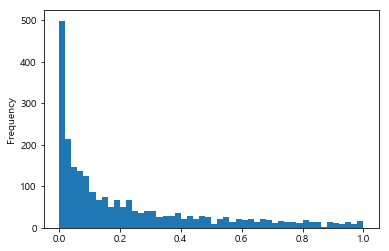

In [31]:
data_num_scaled.R.plot.hist(bins=50)

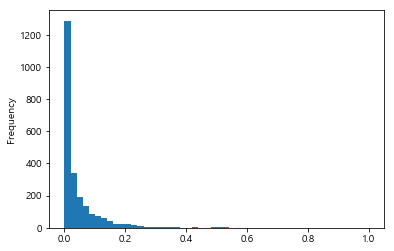

In [30]:
data_num_scaled.F.plot.hist(bins=50)

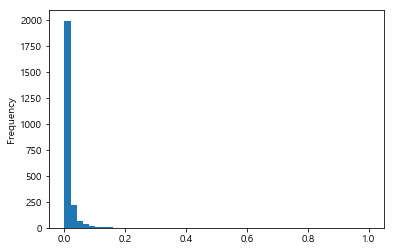

In [29]:
data_num_scaled.M.plot.hist(bins=50)

In [36]:
# M이 1인 경우 제외
data_num_scaled.drop(1316,axis=0, inplace=True)

In [40]:
# F가 아주 큰 경우 제외
data_num_scaled = data_num_scaled.query('F<0.9')

In [59]:
fig = px.scatter_3d(data_num_scaled ,x = "R",y = "F",z = "M")
fig.show()

### 자주 방문에서 많은 금액을 쓴 충성고객들은 최근에도 방문했음. 즉 여전히 우리 매장을 이용중!
=> 이탈한 고객들, 방문한지 오래된 고객들은 자주 방문하지도 않았고 돈도 얼마 안썼음(낮은 등급이겠군)

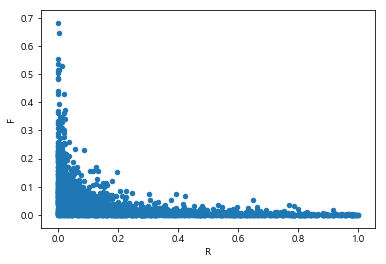

In [56]:
data_num_scaled.iloc[:,[0,1]].plot.scatter(x="R",y="F")

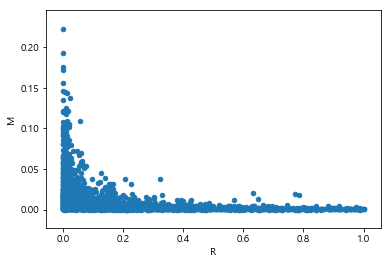

In [57]:
data_num_scaled.iloc[:,[0,2]].plot.scatter(x="R",y="M")

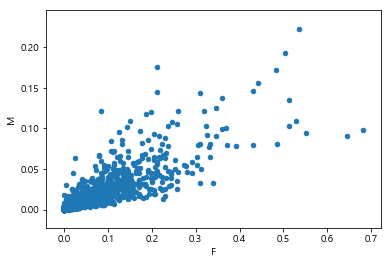

In [58]:
data_num_scaled.iloc[:,[1,2]].plot.scatter(x="F",y="M")

In [154]:
scaler = MinMaxScaler()
data_num_scaled = pd.DataFrame(scaler.fit_transform(RFM18.df.loc[:,["R","F","M"]]), columns = ["R","F","M"])
data_num_scaled.index = RFM18.df.index
data_num_scaled = data_num_scaled.query('F<0.9 or M<0.15')
data_num_scaled["gaip_group"] = (RFM18.df.gaip_date.map(lambda x:x.year)==2018).astype(int)
data_num_scaled

fig = px.scatter_3d(data_num_scaled ,x = "R",y = "F",z = "M",color = data_num_scaled["gaip_group"],opacity=0.7)
fig.show()

In [155]:
scaler = MinMaxScaler()
data_num_scaled2 = pd.DataFrame(scaler.fit_transform(RFM19.df.loc[:,["R","F","M"]]), columns = ["R","F","M"])
data_num_scaled2.index = RFM19.df.index
data_num_scaled2 = data_num_scaled2.query('F<0.9 or M<0.15')
data_num_scaled2["gaip_group"] = (RFM19.df.gaip_date.map(lambda x:x.year)==2019).astype(int)
data_num_scaled2

fig = px.scatter_3d(data_num_scaled2 ,x = "R",y = "F",z = "M",color = data_num_scaled2["gaip_group"],opacity=0.7)
fig.show()

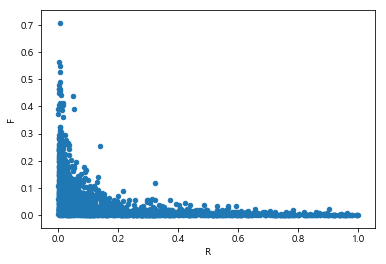

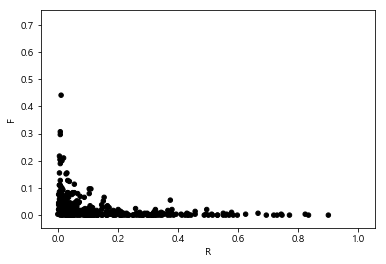

In [161]:
data_num_scaled.loc[:,["R","F"]].plot.scatter(x="R",y="F")
data_num_scaled.loc[:,["R","F"]].plot.scatter(x="R",y="F", color = data_num_scaled.gaip_group)

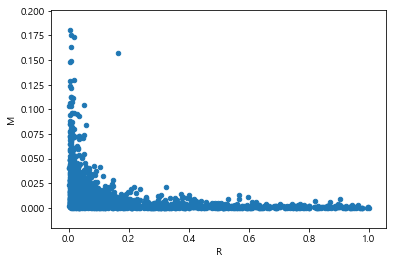

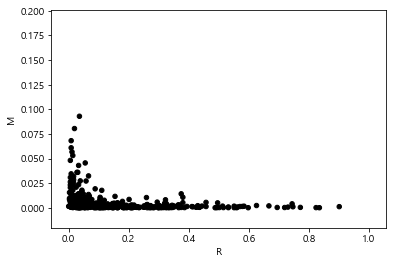

In [162]:
data_num_scaled.loc[:,["R","M"]].plot.scatter(x="R",y="M")
data_num_scaled.loc[:,["R","M"]].plot.scatter(x="R",y="M", color = data_num_scaled.gaip_group)

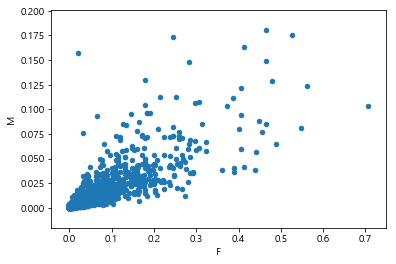

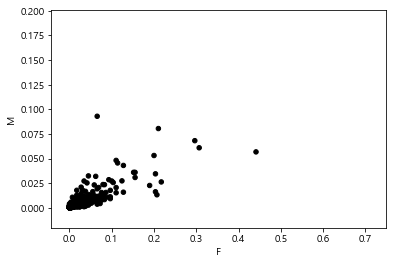

In [163]:
data_num_scaled.loc[:,["F","M"]].plot.scatter(x="F",y="M")
data_num_scaled.loc[:,["F","M"]].plot.scatter(x="F",y="M",color = data_num_scaled.gaip_group)

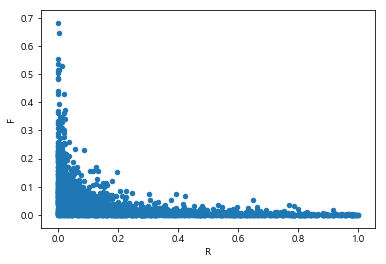

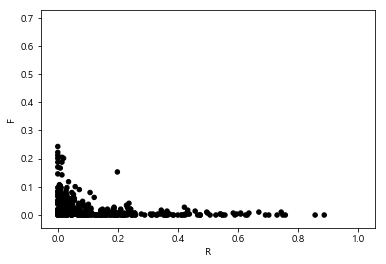

In [164]:
data_num_scaled2.loc[:,["R","F"]].plot.scatter(x="R",y="F")
data_num_scaled2.loc[:,["R","F"]].plot.scatter(x="R",y="F", color = data_num_scaled2.gaip_group)

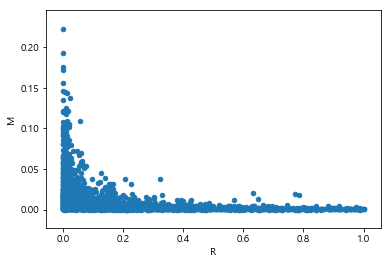

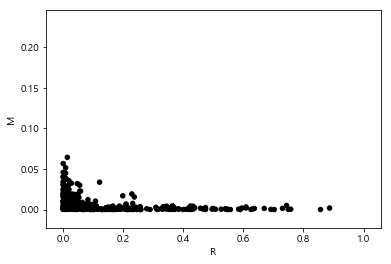

In [165]:
data_num_scaled2.loc[:,["R","M"]].plot.scatter(x="R",y="M")
data_num_scaled2.loc[:,["R","M"]].plot.scatter(x="R",y="M", color = data_num_scaled2.gaip_group)

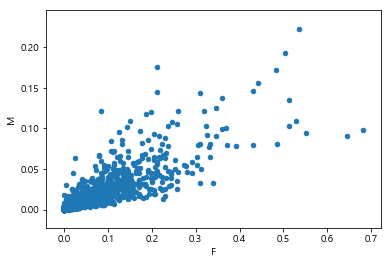

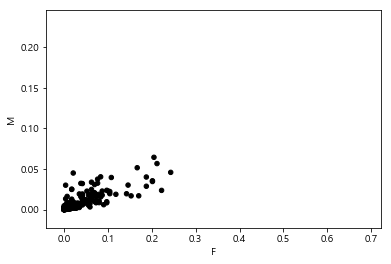

In [166]:
data_num_scaled2.loc[:,["F","M"]].plot.scatter(x="F",y="M")
data_num_scaled2.loc[:,["F","M"]].plot.scatter(x="F",y="M",color = data_num_scaled2.gaip_group)

# 18년 고객이 19년에 어떻게 됐을까?

In [268]:
test = pd.merge(RFM18.df.score_cluster_id,RFM19.df.score_cluster_id,how="left", left_index=True,right_index=True).fillna(0)
grade_dic = {1:"4등급", 2:"3등급",3:"2등급",4:"1등급",0:"★이탈"}
test = test.applymap(lambda x:grade_dic[x])
test.columns=["grade18","grade19"]

In [269]:
test

,grade18,grade19
C118113,4등급,★이탈
C118291,3등급,2등급
C118294,4등급,3등급
C118295,4등급,4등급
C118298,3등급,3등급
...,...,...
C643538,4등급,3등급
C643700,4등급,2등급
C644185,3등급,1등급
C644507,4등급,2등급


#### 이탈에 나이대가 크게 중요한 요소는 아닌듯

In [35]:
idx = test.query("grade_=='★이탈'").index
idx2 = test.query("grade_!='★이탈'").index

In [36]:
df_members[df_members.customer_id.isin(idx)].agegroup.value_counts(normalize=True).round(3)

40대    0.444
50대    0.223
30대    0.185
60대    0.114
70대    0.018
80대    0.010
20대    0.005
Name: agegroup, dtype: float64

In [37]:
df_members[df_members.customer_id.isin(idx2)].agegroup.value_counts(normalize=True).round(3)

40대    0.411
50대    0.261
30대    0.168
60대    0.120
70대    0.031
80대    0.007
20대    0.001
Name: agegroup, dtype: float64

In [270]:
g18to19 = pd.DataFrame(test.groupby(["grade18"])["grade19"].value_counts()).sort_index()

g18to19.unstack(level=0).fillna("-")

grade19                   
grade18     1등급    2등급    3등급  4등급
grade19                           
1등급          64   21.0    8.0    -
2등급          21  143.0  101.0    8
3등급           4   91.0  454.0  204
4등급           1    3.0  157.0  378
★이탈           -    1.0   36.0  357

* 모든 등급에서 등급을 유지한 인원이 가장 많았다.
* 4등급의 경우 유지한 인원수와 이탈한 인원수가 비슷할 정도로 많은 이탈이 발생했다.

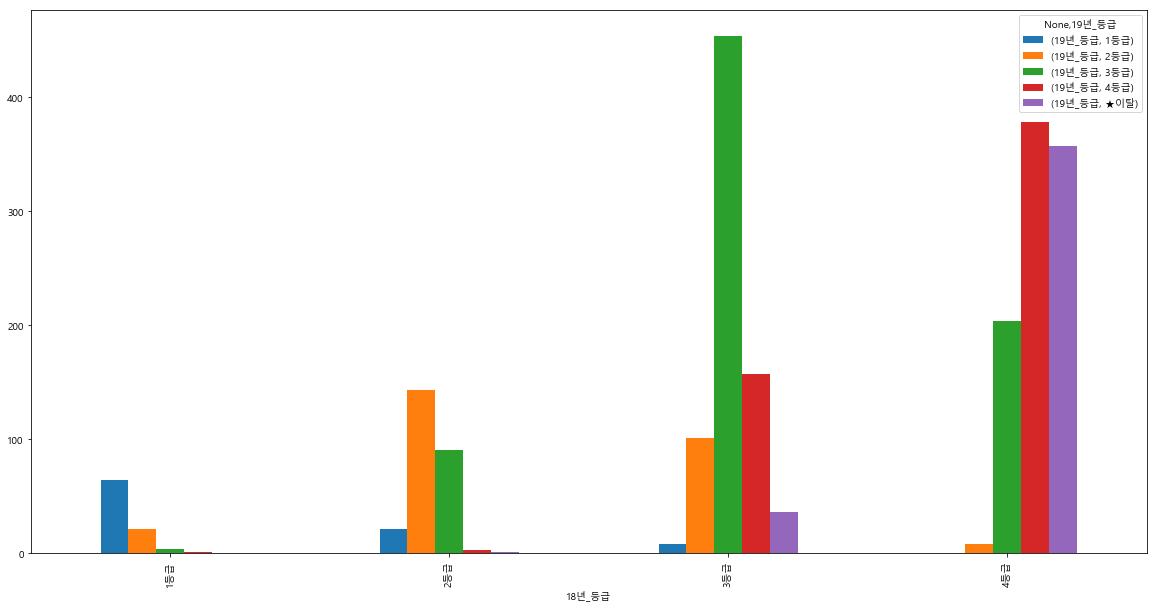

In [419]:
g18to19.unstack(level=1).plot.bar(figsize=(20,10))

In [271]:
g18to19_pct = (g18to19/g18to19.groupby("grade18").sum()).round(3)
g18to19_pct

grade19
grade18 grade19         
1등급     1등급        0.711
        2등급        0.233
        3등급        0.044
        4등급        0.011
2등급     1등급        0.081
        2등급        0.552
        3등급        0.351
        4등급        0.012
        ★이탈        0.004
3등급     1등급        0.011
        2등급        0.134
        3등급        0.601
        4등급        0.208
        ★이탈        0.048
4등급     2등급        0.008
        3등급        0.215
        4등급        0.399
        ★이탈        0.377

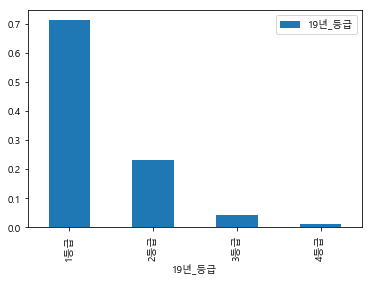

In [447]:
g18to19_pct.loc["1등급"].plot.bar()

# 기존 등급과 새로운 등급간 비교

In [272]:
new_g_18 = pd.DataFrame(RFM18.df.groupby("grade").score_cluster_id.value_counts())
new_g_18.index.names = ["기존등급","RFM등급"]
new_g_18.columns = ["인원"]
new_g_18

인원
기존등급      RFM등급     
1Royal    4       42
          3       29
          2       11
          1        6
2Platinum 2      336
          3      147
          1      125
          4       37
3Gold     1      628
          2      383
          3       80
          4       11
4Silver   1      188
          2       26
          3        3

In [273]:
new_g_18 = pd.DataFrame(RFM18.df.groupby("score_cluster_id").grade.value_counts()).sort_index()
new_g_18.index.names = ["RFM등급","기존등급"]
new_g_18.columns = ["인원"]
new_g_18

인원
RFM등급 기존등급          
1     1Royal       6
      2Platinum  125
      3Gold      628
      4Silver    188
2     1Royal      11
      2Platinum  336
      3Gold      383
      4Silver     26
3     1Royal      29
      2Platinum  147
      3Gold       80
      4Silver      3
4     1Royal      42
      2Platinum   37
      3Gold       11

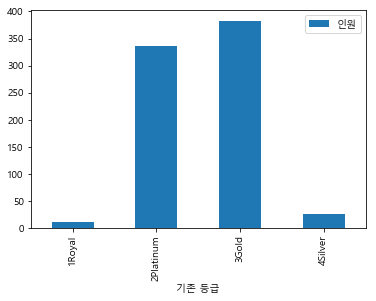

In [411]:
new_g_18.loc[2].plot.bar()

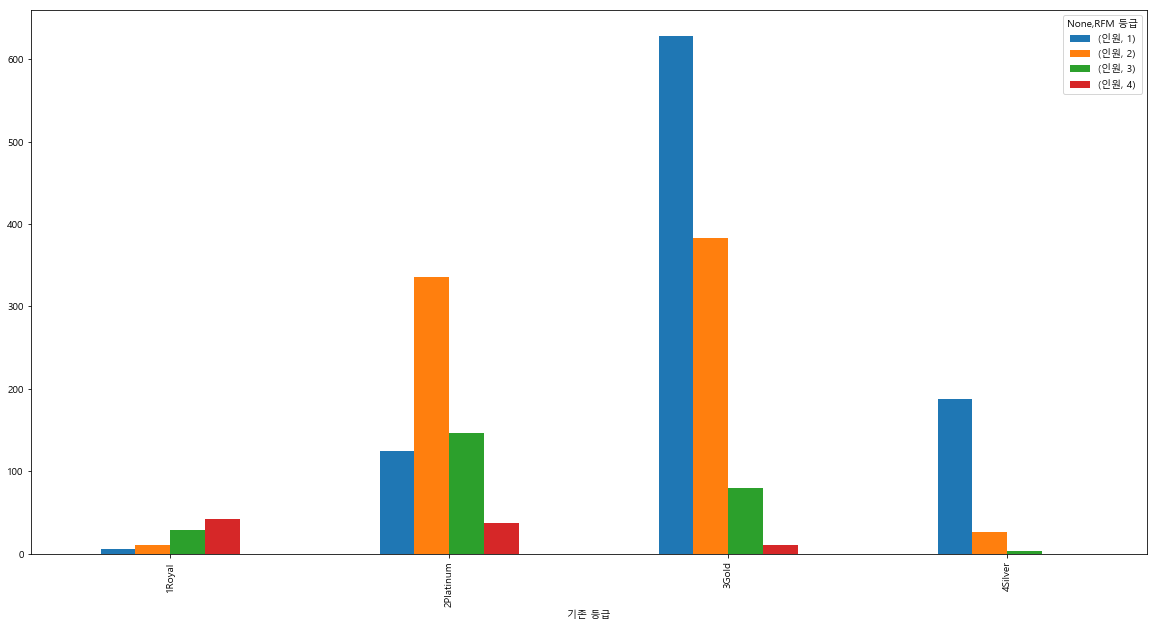

In [407]:
new_g_18.unstack(level=0).plot.bar(figsize=(20,10))

In [378]:
new_g_19 = pd.DataFrame(RFM19.df.groupby("grade").score_cluster_id.value_counts())
new_g_19.index.names = ["기존등급","RFM등급"]
new_g_19.columns = ["인원"]
new_g_19

인원
기존 등급     RFM 등급     
1Royal    4        46
          3        23
          2        13
          1         7
2Platinum 2       371
          3       179
          1       125
          4        38
3Gold     1       667
          2       535
          3       100
          4        16
4Silver   1       210
          2        29
          3         2

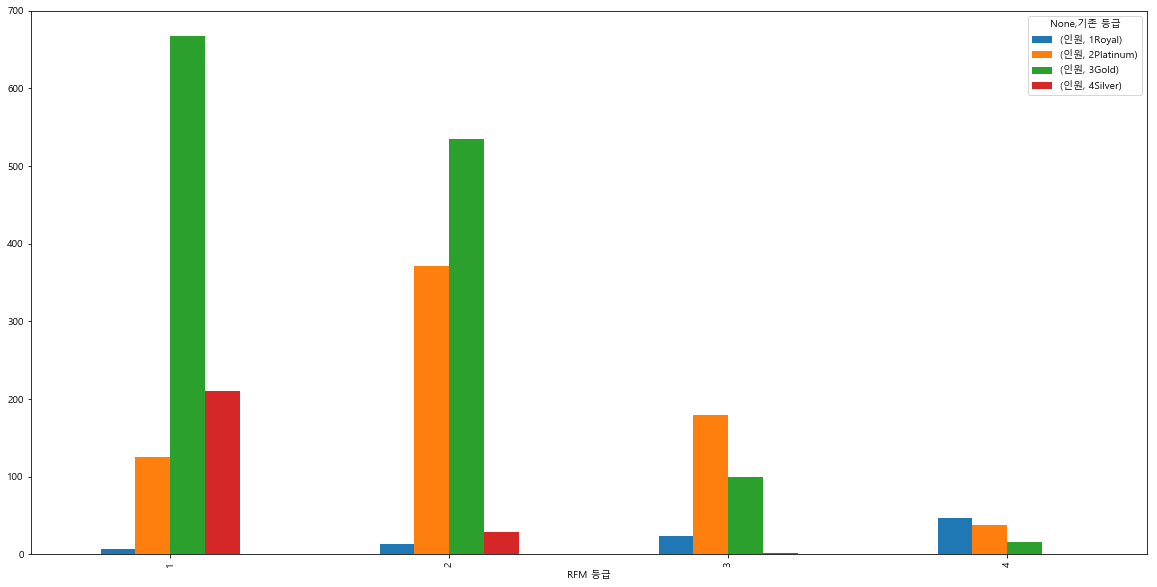

In [379]:
new_g_19.unstack(level=0).plot.bar(figsize=(20,10))

### 이탈고객...들은...그냥 다 낮네

In [274]:
churn_id = test[test["grade19"]=='★이탈'].index
churn_id

Index(['C118113', 'C118721', 'C119412', 'C121524', 'C122866', 'C123900',
       'C125000', 'C128434', 'C129906', 'C131684',
       ...
       'C618059', 'C619340', 'C627481', 'C627604', 'C628156', 'C628642',
       'C630465', 'C631649', 'C636015', 'C636996'],
      dtype='object', length=394)

In [275]:
RFM18.df.loc[churn_id]

,grade,gaip_date,R,F,M,R_class,F_class,M_class,score,score_cluster_id
C118113,3Gold,2011-12-06,39,3,99500,5,1,3,1.650191,1
C118721,4Silver,2011-12-18,191,1,14100,3,1,2,1.325095,1
C119412,3Gold,2012-01-01,116,3,10700,4,1,2,1.384136,1
C121524,3Gold,2012-01-23,129,5,233650,4,2,4,2.532109,2
C122866,3Gold,2012-02-19,299,1,30400,2,1,2,1.266054,1
...,...,...,...,...,...,...,...,...,...,...
C628642,3Gold,2018-09-23,12,3,103650,5,1,3,1.650191,1
C630465,3Gold,2018-10-04,76,1,45050,4,1,3,1.591150,1
C631649,4Silver,2018-10-10,9,1,26200,5,1,2,1.443177,1
C636015,4Silver,2018-11-01,35,1,18400,5,1,2,1.443177,1


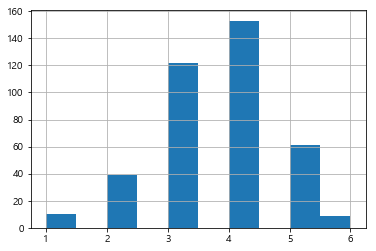

In [283]:
RFM18.df.loc[churn_id].R_class.hist()

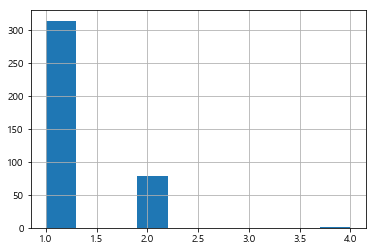

In [282]:
RFM18.df.loc[churn_id].F_class.hist()

In [286]:
# 주로 F가 낮은(즉 몇번 방문하지 않은) 고객들이 이탈했음
RFM18.df.loc[churn_id].F_class.value_counts()

1    314
2     79
4      1
Name: F_class, dtype: int64

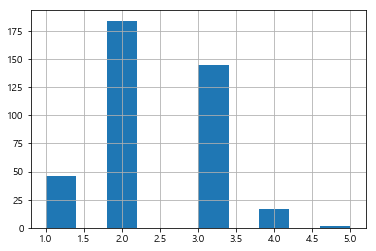

In [281]:
RFM18.df.loc[churn_id].M_class.hist()

# 고객 1명이 1년동안 소비하는 금액이 크게 하락했음
* R과 F는 18년과 19년 중앙값에 큰 차이가 없음
* 그러나 M의 경우 약 5만원정도 차이가 있음
* 한 명당 소비금액을 올리는 것이 중요해보임.

In [299]:
pd.DataFrame({"18년 중앙값":RFM18.df.iloc[:,1:5].median(),"19년 중앙값":RFM19.df.iloc[:,1:5].median(),"18년 가중치":RFM18.w,"19년 가중치":RFM19.w}).round(2)

,18년 중앙값,19년 중앙값,18년 가중치,19년 가중치
R,37.0,40.0,0.06,0.05
F,6.0,5.0,0.73,0.74
M,130580.0,86650.0,0.21,0.21


In [293]:
RFM18.df.describe().round(3)

,R,F,M,R_class,F_class,M_class,score,score_cluster_id
count,2052.000,2052.000,2.052000e+03,2052.000,2052.000,2052.000,2052.000,2052.000
mean,74.987,14.865,4.183757e+05,4.538,1.959,3.318,2.392,1.752
std,87.555,22.835,1.075351e+06,1.080,0.912,1.113,0.909,0.838
min,0.000,1.000,8.000000e+02,1.000,1.000,1.000,1.000,1.000
25%,11.000,2.000,3.800000e+04,4.000,1.000,3.000,1.532,1.000
50%,37.000,6.000,1.305800e+05,5.000,2.000,3.000,2.384,2.000
75%,112.000,18.000,4.391800e+05,5.000,2.000,4.000,2.976,2.000
max,363.000,291.000,3.651786e+07,6.000,6.000,6.000,6.000,4.000


In [294]:
RFM19.df.describe().round(3)

,R,F,M,R_class,F_class,M_class,score,score_cluster_id
count,2361.000,2361.000,2.361000e+03,2361.000,2361.000,2361.000,2361.000,2361.000
mean,81.637,13.515,2.893998e+05,4.501,1.899,3.243,2.318,1.786
std,93.169,21.310,7.243256e+05,1.147,0.910,1.127,0.915,0.825
min,0.000,1.000,1.000000e+03,1.000,1.000,1.000,1.000,1.000
25%,11.000,2.000,2.505000e+04,4.000,1.000,2.000,1.466,1.000
50%,40.000,5.000,8.665000e+04,5.000,2.000,3.000,2.315,2.000
75%,124.000,17.000,3.057000e+05,5.000,2.000,4.000,2.631,2.000
max,363.000,289.000,2.514444e+07,6.000,6.000,6.000,6.000,4.000


In [47]:
pd.DataFrame({"18년":RFM18.df.score_cluster_id.value_counts(),"18년 pct":RFM18.df.score_cluster_id.value_counts(normalize=True)
              ,"19년":RFM19.df.score_cluster_id.value_counts(),"19년 pct" : RFM19.df.score_cluster_id.value_counts(normalize=True)}).round(3)

,18년,18년 pct,19년,19s년 pct
1,947,0.462,1009,0.427
2,756,0.368,948,0.402
3,259,0.126,304,0.129
4,90,0.044,100,0.042


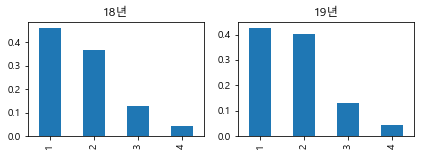

In [53]:
plt.subplot(2, 2, 1) 
RFM18.df.score_cluster_id.value_counts(normalize=True).plot.bar()
plt.title('18년')
plt.subplot(2, 2, 2) 
RFM19.df.score_cluster_id.value_counts(normalize=True).plot.bar()
plt.title('19년')
plt.tight_layout()
plt.show()

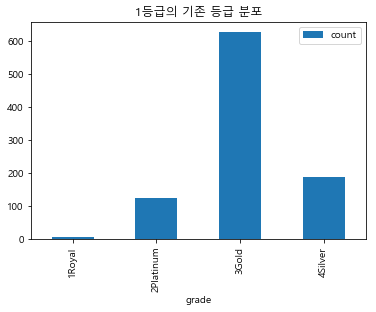

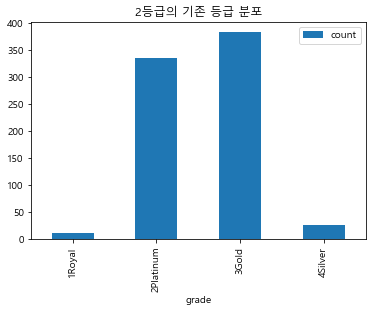

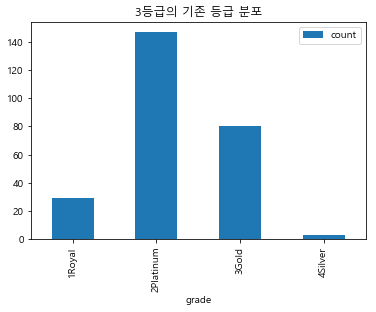

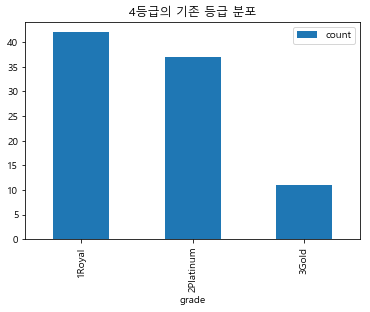

In [88]:
for i in range(1,5): 
    RFM18.summary_score.loc[i].plot.bar()
    plt.title(str(i)+"등급의 기존 등급 분포")

# 기존회원들의 상태는?

In [314]:
cus = df_members.query('gaip_date<"2017-12-31"').customer_id

In [301]:
print("18년에 활동한 기존 회원수 : ",sum(RFM18.df.index.isin(cus)))

18년에 활동한 기존 회원수 :  1630


In [315]:
RFM18.df

,grade,gaip_date,R,F,M,R_class,F_class,M_class,score,score_cluster_id
C118113,3Gold,2011-12-06,39,3,99500,5,1,3,1.650191,1
C118291,1Royal,2011-12-11,28,16,541300,5,2,4,2.591150,2
C118294,2Platinum,2011-12-11,140,4,45150,4,2,3,2.325095,1
C118295,3Gold,2011-12-11,283,4,81700,3,2,3,2.266054,1
C118298,2Platinum,2011-12-11,12,28,214990,5,3,4,3.325095,2
...,...,...,...,...,...,...,...,...,...,...
C643538,3Gold,2018-12-11,11,1,34500,5,1,3,1.650191,1
C643700,2Platinum,2018-12-11,6,2,48750,6,1,3,1.709232,1
C644185,2Platinum,2018-12-14,1,7,68990,6,2,3,2.443177,2
C644507,3Gold,2018-12-16,6,3,83700,6,1,3,1.709232,1


In [316]:
RFM18.df.iloc[RFM18.df.index.isin(cus)].score_cluster_id.value_counts().round(3).loc[[1,2,3,4]]

1    709
2    607
3    231
4     83
Name: score_cluster_id, dtype: int64

In [317]:
print("19년에 활동한 기존 회원수 : ",sum(RFM19.df.index.isin(cus)))

19년에 활동한 기존 회원수 :  1490


In [318]:
RFM19.df.iloc[RFM19.df.index.isin(cus)].score_cluster_id.value_counts().round(3).loc[[1,2,3,4]]

1    580
2    613
3    218
4     79
Name: score_cluster_id, dtype: int64

In [158]:
print("18년과 19년에 모두 활동한 17년 가입자수 :", len(flow))

18년과 19년에 모두 활동한 17년 가입자수 : 1309


# 전체 고객의 등급 이동별 프로모션 결과 확인하기

In [135]:
# 18년 등급과 19년 등급을 추출
res18 = RFM19.df[['score_cluster_id']]
res18 = res19.reset_index()
res19 = RFM19.df[['score_cluster_id']]
res19 = res19.reset_index()

# 모든 고객(약 6000명)의 id 추출
res = df_members[['customer_id']]
res.columns = ['index']

,index,score_cluster_id
0,C118291,3
1,C118294,2
2,C118295,1
3,C118298,2
4,C118299,1
...,...,...
2356,C704198,2
2357,C704239,1
2358,C704271,2
2359,C704612,1


In [228]:
# 등급 이동별 프로모션을 매칭

result = pd.merge(pd.merge(res,res18,on='index',how='outer'),res19,on='index',how='outer')
result.fillna(0.1, inplace=True)
result.columns = ['customer_id',"grade18",'grade19']

result['grade_diff'] = result.grade19-result.grade18

promo = {0:np.nan,-0.9:"첫 구매 할인 쿠폰 제공",3:"기념일 선물 증정 및 신상품 체험 기회 부여",2:"선호 상품 광고 문자 전송 및 만족도 조사 실시",
        1:"선호 상품 광고 문자 전송 및 만족도 조사 실시",
        -2:"불만 사항 설문조사 실시 및 선호 상품 할인 쿠폰 제공",
        -1:"불만 사항 설문조사 실시 및 선호 상품 할인 쿠폰 제공",
        -3:"불만 사항 설문조사 실시 및 선호 상품 할인 쿠폰 제공"}
gradedict = {0.1:"Silver_",1:"Silver",2:"Gold",3:"Platinum",4:"Royal"}

result['promotion'] = result['grade_diff'].map(promo)
result.grade18 = result.grade18.map(gradedict)
result.grade19 = result.grade19.map(gradedict)

royal = result.query('grade18=="Royal" and grade19=="Royal"').index
for i in royal:
    result.loc[i,'promotion'] = "정기 배송 서비스 제공"

customer_id         C122517
grade18               Royal
grade19               Royal
grade_diff                0
promotion      정기 배송 서비스 제공
Name: 56, dtype: object
customer_id         C126695
grade18               Royal
grade19               Royal
grade_diff                0
promotion      정기 배송 서비스 제공
Name: 85, dtype: object
customer_id         C129286
grade18               Royal
grade19               Royal
grade_diff                0
promotion      정기 배송 서비스 제공
Name: 103, dtype: object
customer_id         C137485
grade18               Royal
grade19               Royal
grade_diff                0
promotion      정기 배송 서비스 제공
Name: 173, dtype: object
customer_id         C138538
grade18               Royal
grade19               Royal
grade_diff                0
promotion      정기 배송 서비스 제공
Name: 178, dtype: object
customer_id         C138631
grade18               Royal
grade19               Royal
grade_diff                0
promotion      정기 배송 서비스 제공
Name: 184, dtype: object
customer_id 

In [229]:
result

,customer_id,grade18,grade19,grade_diff,promotion
0,C102666,Silver_,Silver_,0.0,NaN
1,C118113,Silver,Silver_,-0.9,첫 구매 할인 쿠폰 제공
2,C118133,Silver_,Silver_,0.0,NaN
3,C118278,Silver_,Silver_,0.0,NaN
4,C118280,Silver_,Silver_,0.0,NaN
...,...,...,...,...,...
6008,C705804,Silver_,Silver_,0.0,NaN
6009,C706457,Silver_,Silver_,0.0,NaN
6010,C707942,Silver_,Silver_,0.0,NaN
6011,C707954,Silver_,Silver_,0.0,NaN


In [230]:
result.loc[:,['grade18','grade19']] = result.loc[:,['grade18','grade19']].applymap(lambda x:"Silver" if x=="Silver_" else x)
result.grade_diff = result.grade_diff.astype(int)
result.to_csv('C:\\Users\\haeyu\\df_promotion.csv', encoding='cp949')